This notebook was given to me by Dr Helfrid Hochegger. I did not write any code in this myself. I will make the least possible changes as I want to copy the methods from this into a different notebook to get some data from Omero and hopefully speed up some of this.

In [ ]:
import os
from os import listdir
from omero.gateway import BlitzGateway
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from skimage import (
    io, exposure, feature, filters, measure, segmentation, color, morphology
)
from tqdm import tqdm
# To plot pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

from stardist.models import StarDist2D
from csbdeep.utils import normalize
model = StarDist2D.from_pretrained('2D_versatile_fluo')

PRD="."
Dir_name='MI_CNN_Trainingdata'
D_PATH = os.path.join(PRD, Dir_name)
os.makedirs(D_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(D_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def save_img(image, filename):
    path = os.path.join(D_PATH, filename)
    io.imsave(path, image)

In [2]:
def Stardist(image):
    #image1=filters.gaussian(image, sigma=1, mode='nearest')
    #cleared = segmentation.clear_border(image1)
    label_objects, nb_labels = model.predict_instances(normalize(image))
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = (sizes > 75) & (sizes < 2000)
    mask_sizes[0] = 0
    cells_cleaned = mask_sizes[label_objects]
    segmented_cells_, cell_number = ndi.label(cells_cleaned)
    color_labels = color.label2rgb(segmented_cells_, image, alpha=0.4, bg_label=0)
    return segmented_cells_, color_labels, cell_number

In [3]:
Image_ID=247869


In [4]:
conn = BlitzGateway('helfrid', 'Omero_21', host='ome2.hpc.sussex.ac.uk')
conn.connect()





True

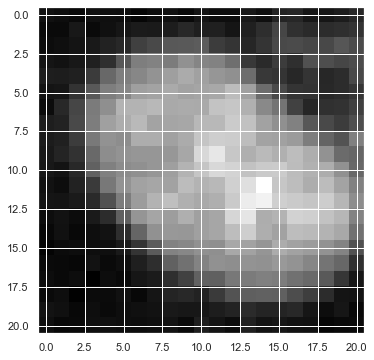

ValueError: invalid literal for int() with base 10: ''

In [5]:
object= conn.getObject("Image", Image_ID)
pixels=object.getPrimaryPixels()
timepoints=[20]
score=0
sample_number=100
dict_all1={'target':[],'data':[]}
w=10
for i in timepoints:
    img=pixels.getPlane(0,0,i)
    percentiles = np.percentile(img, (2, 98))
    scaled = exposure.rescale_intensity(img, in_range=tuple(percentiles))
    Segmented, ColorLabels, Cell_Number =Stardist(scaled)

    for region in random.sample(measure.regionprops(Segmented),sample_number):
        b=img[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]]
        if 10 <= len(b) <= 30:
            centroid = region.centroid
            i=centroid[0]
            j=centroid[1]
            imin = int(round(max(0,i-w)))
            imax = int(round(min(Segmented.shape[0],i+w+1)))
            jmin = int(round(max(0,j-w)))
            jmax = int(round(min(Segmented.shape[1],j+w+1)))
            box=img[imin:imax,jmin:jmax]
            if box.shape[0]==box.shape[1]:
                sns.set(font='Arial')
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.imshow(img[imin:imax,jmin:jmax],cmap='gray')
                plt.show(block=False)
                time.sleep(1)
                target_value=input()
                target_value=int(target_value)
                dict_all1['target'].append(target_value)
                dict_all1['data'].append(box)



In [13]:

np.save(os.path.join(D_PATH,'MI_CNN_data19.npy'),dict_all1)